## **1. Descripci√≥n del problema y del conjunto de datos**

En este proyecto abordamos un problema de **clasificaci√≥n de d√≠gitos manuscritos en notaci√≥n europea**.  
A diferencia del cl√°sico conjunto de datos **MNIST**, que contiene d√≠gitos escritos al estilo americano, este conjunto incluye im√°genes de d√≠gitos manuscritos recogidos en **Suiza**, lo que introduce diferencias estil√≠sticas notables, especialmente en la escritura de los n√∫meros **1** y **7**, que com√∫nmente generan confusi√≥n.

### **Caracter√≠sticas del conjunto de datos:**

- **Cantidad de im√°genes:** 21,600
- **Etiquetas:** D√≠gitos del 0 al 9
- **Formato de archivo:** `.jpg`
- **Dimensiones de imagen:** **90x140 p√≠xeles**
- **Canales:** Im√°genes en color (**3 canales RGB**)

Este conjunto de datos representa un **reto adicional frente a MNIST**, ya que no solo tiene mayor resoluci√≥n y color, sino que adem√°s incorpora **variaciones estil√≠sticas propias de una regi√≥n distinta**.  
Esto lo convierte en una opci√≥n m√°s realista y exigente para el entrenamiento de modelos robustos de **clasificaci√≥n de im√°genes manuscritas**.

In [1]:
# Importar todas las librer√≠as necesarias
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import warnings
import time
# Librer√≠as de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Configurar el directorio de datos
data_dir = "../handwritten-digits-0-9" #cambia esto por tu directorio de datos

## **2. Visualizaci√≥n e inspecci√≥n de los datos**

Para entender mejor los datos, se utilizaron las siguientes **herramientas de visualizaci√≥n**:

- **Muestra de im√°genes:**  
  Se reconstruyen algunas im√°genes a partir de los valores de los p√≠xeles para visualizar los d√≠gitos.

- **Histograma de clases:**  
  Permite observar el **balance de clases** en el conjunto.

- **Matriz de correlaci√≥n** (cuando aplica):  
  √ötil en casos de datos tabulares, para ver la **relaci√≥n entre variables**.

- **Gr√°ficos de dispersi√≥n PCA o t-SNE:**  
  Se usaron para **reducir la dimensionalidad** y visualizar la distribuci√≥n de las clases.

Estas visualizaciones ayudan a detectar problemas como **clases desbalanceadas**, **im√°genes corruptas** o **falta de variedad** en los datos.


CARGANDO Y VISUALIZANDO DATOS...
Visualizando muestras de cada clase (im√°genes originales)...


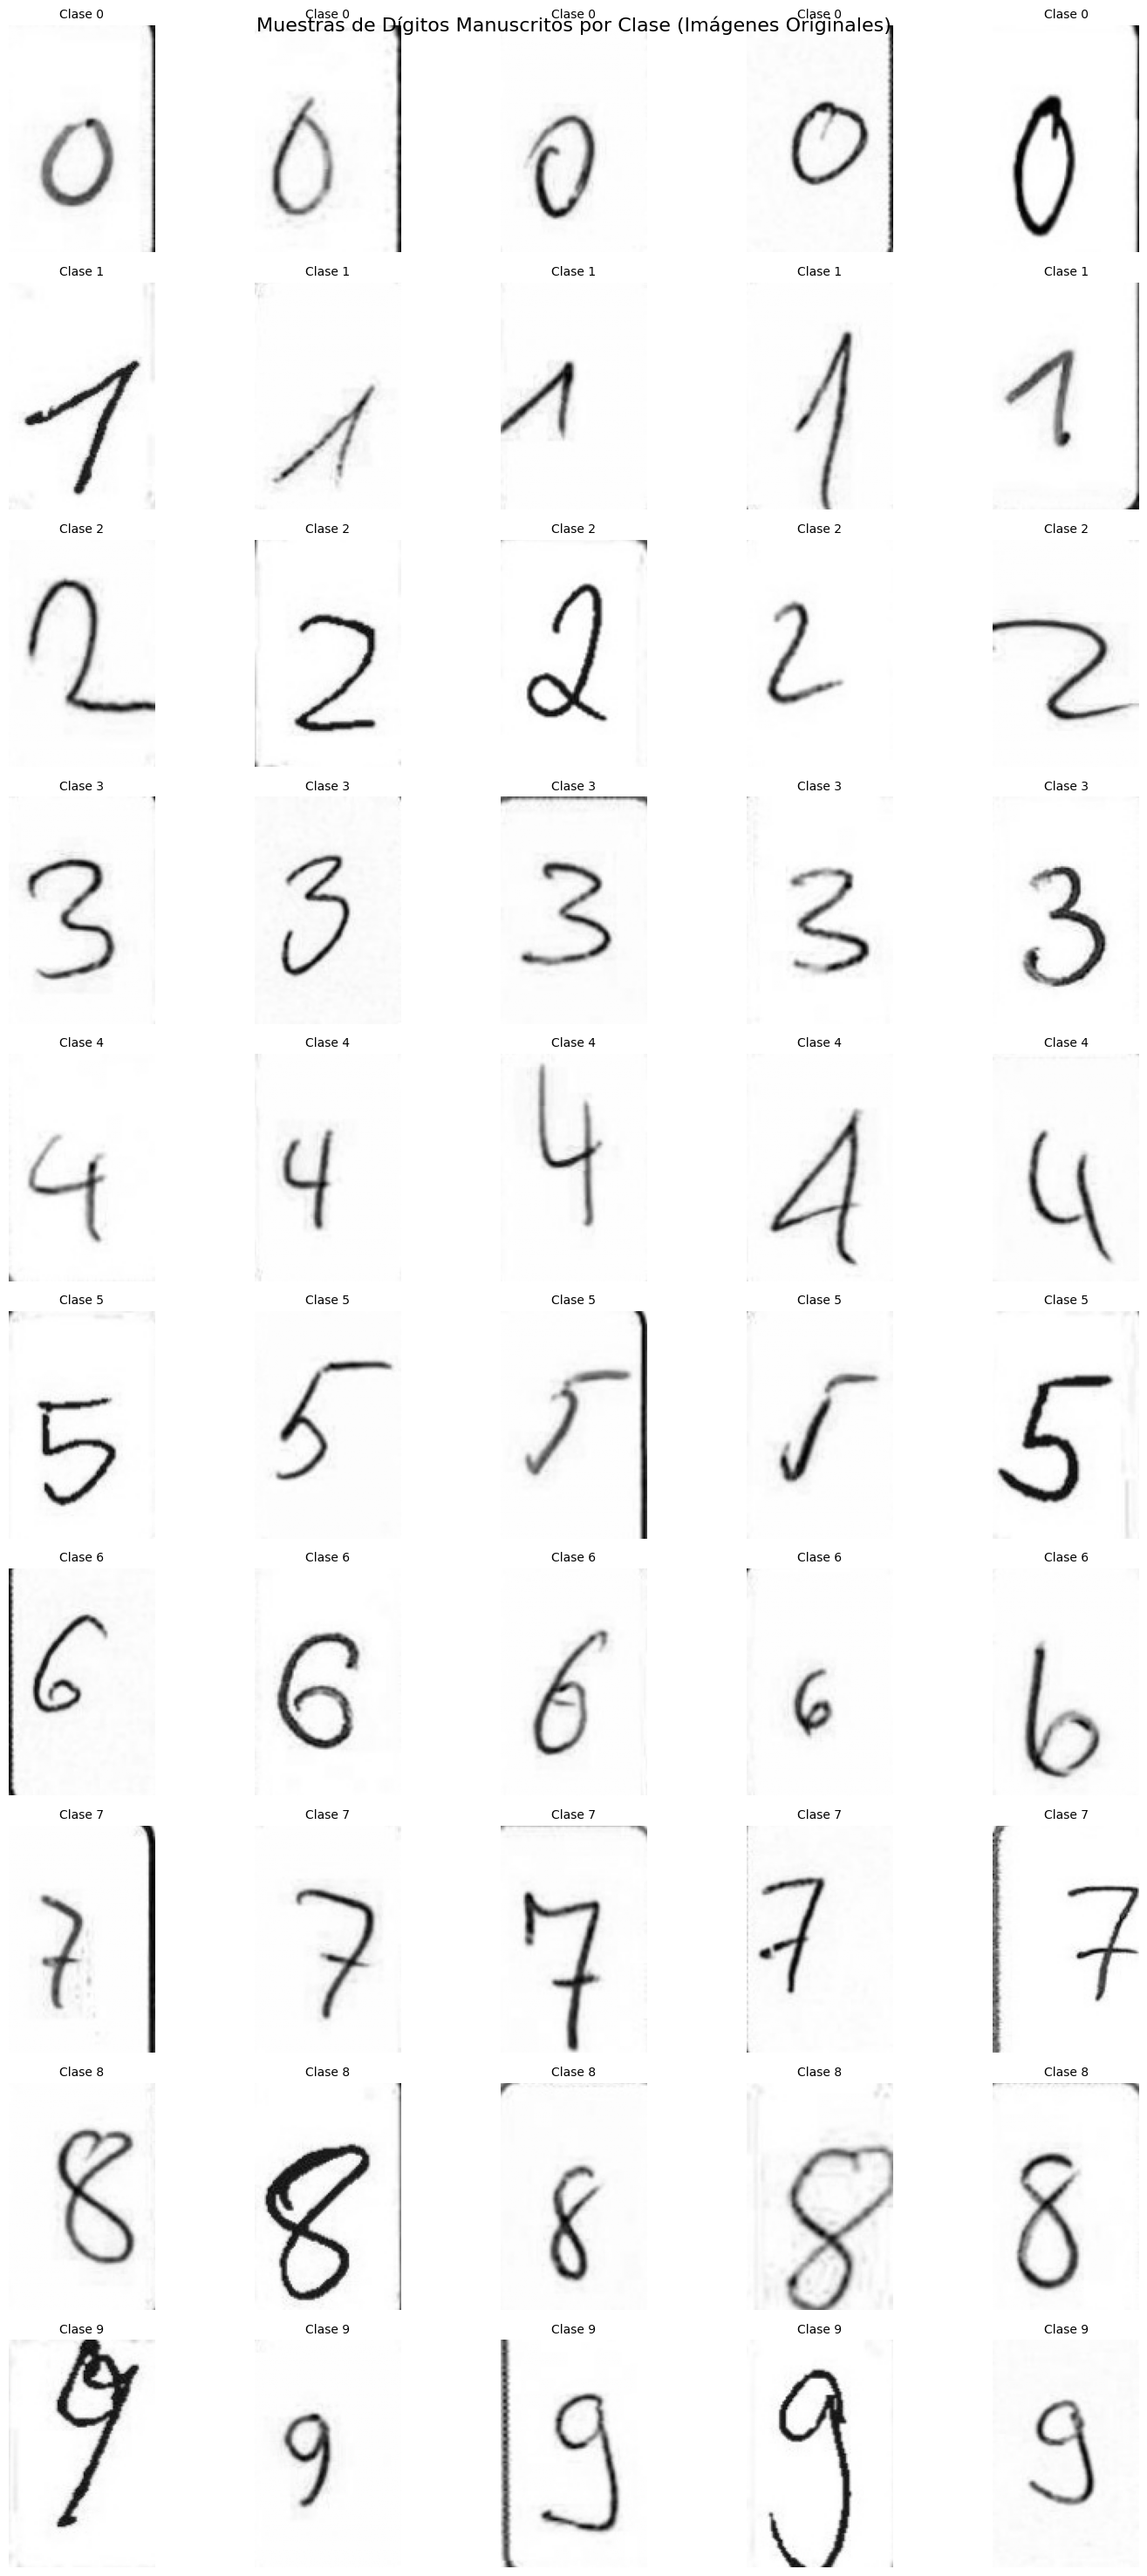

In [6]:

print("\nCARGANDO Y VISUALIZANDO DATOS...")
# Crear diccionario para almacenar im√°genes por d√≠gito
digit_images = {}
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        digit_images[str(label)] = image_files
    else:
        print(f"Advertencia: Carpeta {folder_path} no encontrada")

# Visualizar 5 im√°genes por clase (ORIGINALES)
print("Visualizando muestras de cada clase (im√°genes originales)...")
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
for label, image_files in digit_images.items():
    if len(image_files) >= 5:
        chosen_images = np.random.choice(image_files, 5, replace=False)
        for i, image_file in enumerate(chosen_images):
            image_path = os.path.join(data_dir, label, image_file)
            try:
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    ax = axes[int(label), i]
                    ax.imshow(img, cmap='gray')
                    ax.set_title(f"Clase {label}", fontsize=10)
                    ax.axis('off')
            except Exception as e:
                print(f"Error leyendo imagen {image_path}: {e}")

plt.suptitle("Muestras de D√≠gitos Manuscritos por Clase (Im√°genes Originales)", fontsize=16)
plt.tight_layout()
plt.show()

> **Observaci√≥n importante:**  
> Algunas im√°genes contienen un peque√±o borde negro que podr√≠a afectar los resultados del modelo si no se considera en el preprocesamiento.



ANALIZANDO DISTRIBUCI√ìN DE CLASES...


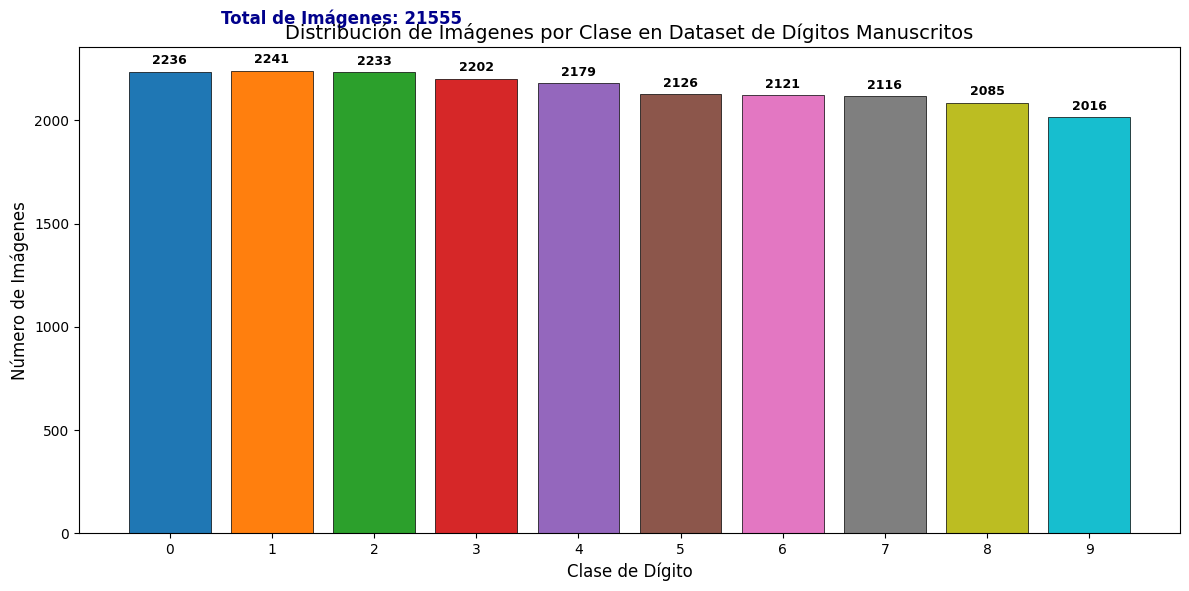

Total de im√°genes en el dataset: 21555
Clase 0: 2236 im√°genes
Clase 1: 2241 im√°genes
Clase 2: 2233 im√°genes
Clase 3: 2202 im√°genes
Clase 4: 2179 im√°genes
Clase 5: 2126 im√°genes
Clase 6: 2121 im√°genes
Clase 7: 2116 im√°genes
Clase 8: 2085 im√°genes
Clase 9: 2016 im√°genes


In [7]:

print("\nANALIZANDO DISTRIBUCI√ìN DE CLASES...")
# Contar im√°genes por clase
digit_counts = {}
total_images = 0
for label in range(10):
    folder_path = os.path.join(data_dir, str(label))
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        digit_counts[str(label)] = len(image_files)
        total_images += len(image_files)

# Crear gr√°fico de barras de distribuci√≥n
labels = list(digit_counts.keys())
counts = list(digit_counts.values())
colors = plt.cm.tab10(range(10))

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color=colors, edgecolor='black', linewidth=0.5)
plt.xlabel("Clase de D√≠gito", fontsize=12)
plt.ylabel("N√∫mero de Im√°genes", fontsize=12)
plt.title("Distribuci√≥n de Im√°genes por Clase en Dataset de D√≠gitos Manuscritos", fontsize=14)
plt.xticks(labels)

# A√±adir estad√≠sticas
plt.text(0.5, max(counts) * 1.1, f"Total de Im√°genes: {total_images}", 
         ha='left', fontsize=12, color='darkblue', weight='bold')

# A√±adir valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + max(counts)*0.01, 
             int(yval), ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

print(f"Total de im√°genes en el dataset: {total_images}")
for label, count in digit_counts.items():
    print(f"Clase {label}: {count} im√°genes")


### **An√°lisis de la distribuci√≥n de las clases**

Al analizar la distribuci√≥n de las clases, se observa que el dataset contiene un total de **21,555 im√°genes** distribuidas en **10 clases** (d√≠gitos del 0 al 9).

Como se ha se√±alado, la distribuci√≥n es **bastante balanceada** y no existen diferencias significativas entre la cantidad de datos por clase. Esto es ideal para el entrenamiento de modelos, ya que reduce el riesgo de sesgo hacia alguna clase espec√≠fica.

## **3. Preprocesamiento y preparaci√≥n de los datos**

Las siguientes estrategias fueron aplicadas para preparar los datos:

- **Normalizaci√≥n:**  
  Se escalan los valores de p√≠xeles entre 0 y 1 dividiendo por 255.

- **Divisi√≥n en entrenamiento y prueba:**  
  Se dividi√≥ el conjunto en **80% para entrenamiento** y **20% para prueba**.

- **Codificaci√≥n (cuando aplica):**  
  No necesaria aqu√≠ porque las etiquetas ya est√°n codificadas como enteros.

- **Balanceo de clases:**  
  Se verific√≥ que las clases estuvieran balanceadas. Si no lo estuvieran, se podr√≠a aplicar **sobremuestreo (SMOTE)** o **submuestreo**.

- **Reducci√≥n de dimensiones:**  
  Mediante **PCA** para acelerar algunos algoritmos, si se considera conveniente.

Este bloque de c√≥digo realizamos el **preprocesamiento de im√°genes de d√≠gitos manuscritos** para prepararlas antes de entrenar un modelo de clasificaci√≥n. A continuaci√≥n se explica cada parte:

---

### **Importaci√≥n de librer√≠as**

- `os`: Para navegar por carpetas y archivos.
- `numpy`: Para operaciones num√©ricas y manejo de arrays.
- `PIL` (Pillow): Para abrir, manipular y procesar im√°genes.
- `scipy.ndimage.center_of_mass`: Para calcular el centro de masa de la imagen.
- `matplotlib.pyplot`: Para visualizaci√≥n de im√°genes y gr√°ficos.

---

### **Funci√≥n `procesar_imagen`**

Esta funci√≥n toma la ruta de una imagen y realiza los siguientes pasos:

1. **Conversi√≥n a escala de grises** y **fondo negro/d√≠gito blanco**.
2. **Recorte de bordes** para eliminar posibles bordes negros.
3. **Mejora de contraste** para resaltar el d√≠gito.
4. **Recorte autom√°tico** alrededor del d√≠gito para eliminar espacio vac√≠o.
5. **Suavizado** con desenfoque gaussiano ligero.
6. **Redimensionado** a 20x20 p√≠xeles.
7. **Padding** para centrar el d√≠gito en una imagen de 28x28 p√≠xeles.
8. **Normalizaci√≥n** de los valores de p√≠xel entre 0 y 1.
9. **Centrado por masa** para que el d√≠gito quede centrado en la imagen.
10. **Devuelve** la imagen como un vector unidimensional (flatten).

---

### **Carga y procesamiento de todas las im√°genes**

- Recorre todas las carpetas dentro de `data_dir`, donde cada carpeta representa una clase (d√≠gito).
- Procesa cada imagen usando la funci√≥n anterior.
- Almacena los vectores procesados en `X` y las etiquetas en `y`.

Finalmente, convierte `X` y `y` a arrays de NumPy y muestra informaci√≥n sobre el n√∫mero de im√°genes procesadas y la forma de los datos resultantes.

---
Todos estos paso nos ayudaron a mejorar los resultados de los modelos que se usaron, el **Recorte de bordes** se implemento al notar en la estapa de visualizacion e inspecion de datos la imagenes tenian bordes y al agregar eliminar esos bordes el rendimiento de los modelos aumento como esperabamos.

In [8]:
import os
import numpy as np
from PIL import Image, ImageOps
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt


def procesar_imagen(ruta_imagen):
    try:
        img = Image.open(ruta_imagen).convert('L')         # Escala de grises
        img = ImageOps.invert(img)                         # Fondo negro, d√≠gito blanco

          # 0. Recorte de 4 p√≠xeles de todos los bordes
        ancho, alto = img.size
        img = img.crop((10, 10, ancho - 10, alto - 10))

        # 1. Mejorar contraste
        from PIL import ImageEnhance, ImageFilter
        img = ImageEnhance.Contrast(img).enhance(2.0)

        # 2. Recorte del d√≠gito
        img_array_raw = np.array(img)
        coords = np.argwhere(img_array_raw < 255)
        if coords.size > 0:
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img.crop((x0, y0, x1, y1))

        # 3. Suavizado ligero
        img = img.filter(ImageFilter.GaussianBlur(radius=0.5))

        # 4. Redimensionar el contenido a 20x20
        img = img.resize((20, 20), Image.LANCZOS)

        # 5. A√±adir padding para centrar en imagen 28x28
        nueva_img = Image.new('L', (28, 28), color=0)
        nueva_img.paste(img, (4, 4))  # Centro aproximado

        # 6. Normalizar y centrar por masa
        img_array = np.array(nueva_img) / 255.0
        cy, cx = center_of_mass(img_array)
        shift_x = int(14 - cx)
        shift_y = int(14 - cy)
        img_array = np.roll(np.roll(img_array, shift_x, axis=1), shift_y, axis=0)

        return img_array.flatten()

    except Exception as e:
        print(f"Error al procesar imagen {ruta_imagen}: {e}")
        return None

# Recorrer carpetas y cargar im√°genes procesadas
X = []
y = []

for etiqueta in os.listdir(data_dir):
    carpeta = os.path.join(data_dir, etiqueta)
    if os.path.isdir(carpeta):
        for archivo in os.listdir(carpeta):
            ruta_imagen = os.path.join(carpeta, archivo)
            vector = procesar_imagen(ruta_imagen)
            if vector is not None:
                X.append(vector)
                y.append(int(etiqueta))

X = np.array(X)
y = np.array(y)

print("N√∫mero de im√°genes procesadas:", len(X))
print("Shape de X:", X.shape)

N√∫mero de im√°genes procesadas: 21555
Shape de X: (21555, 784)


En el siguiente bloque de c√≥digo mostraremos una imagen de cada clase en su formato original y otra ya procesada y lista para el entrenamiento.  
Se puede observar que el fondo de las im√°genes procesadas es negro y el n√∫mero aparece en escala de grises, ya que tras realizar pruebas obtuvimos mejores resultados que usando √∫nicamente el n√∫mero en blanco.

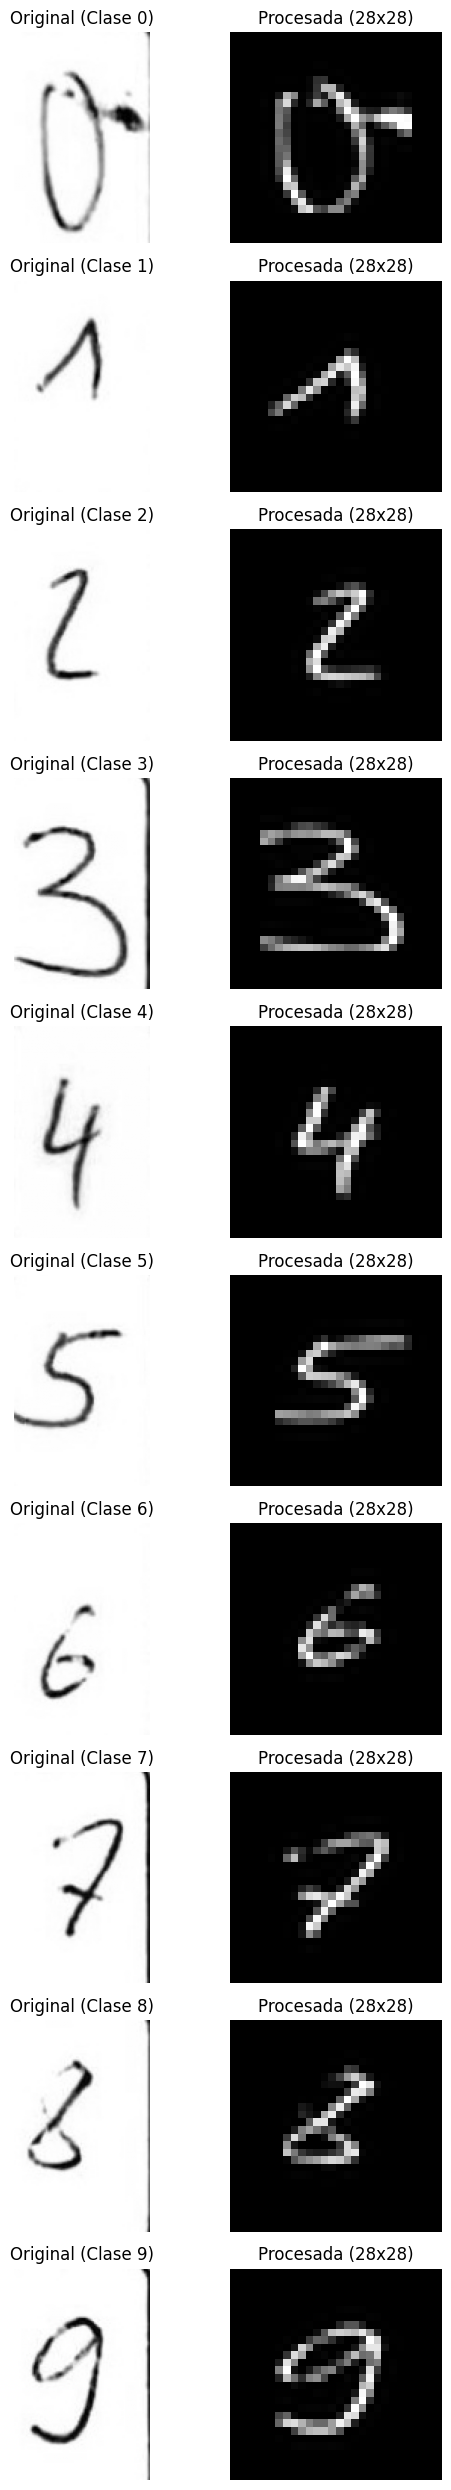

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Mostrar una imagen original y procesada por cada clase
clases = sorted(set(y))  # Extraer clases √∫nicas
fig, axes = plt.subplots(len(clases), 2, figsize=(6, len(clases) * 2.5))

for i, clase in enumerate(clases):
    carpeta = os.path.join(data_dir, str(clase))
    archivos = os.listdir(carpeta)
    
    imagen_mostrada = False
    for archivo in archivos:
        ruta_imagen = os.path.join(carpeta, archivo)
        vector = procesar_imagen(ruta_imagen)
        
        if vector is not None:
            # Mostrar imagen original
            img_original = Image.open(ruta_imagen).convert('L')
            axes[i, 0].imshow(img_original, cmap='gray')
            axes[i, 0].set_title(f'Original (Clase {clase})')
            axes[i, 0].axis('off')
            
            # Mostrar imagen procesada
            img_procesada = vector.reshape(28, 28)
            axes[i, 1].imshow(img_procesada, cmap='gray')
            axes[i, 1].set_title('Procesada (28x28)')
            axes[i, 1].axis('off')
            
            imagen_mostrada = True
            break  # Solo una imagen por clase

    if not imagen_mostrada:
        axes[i, 0].set_title(f'Clase {clase} no encontrada')
        axes[i, 1].set_title('Procesada no disponible')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

 **Reducci√≥n de dimensionalidad con PCA**

Para facilitar la visualizaci√≥n y acelerar el entrenamiento de los modelos, se aplic√≥ **PCA (An√°lisis de Componentes Principales)**. Esta t√©cnica permite reducir el n√∫mero de caracter√≠sticas manteniendo la mayor parte de la varianza del conjunto de datos. As√≠, se logra una representaci√≥n m√°s compacta y eficiente de las im√°genes de d√≠gitos manuscritos.

In [27]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Reducci√≥n con PCA al 95%
print("\nAplicando PCA para reducci√≥n de dimensionalidad...")
pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X)

print(f"Dimensiones originales: {X.shape}")
print(f"Dimensiones despu√©s de PCA: {X_pca.shape}")
print(f"Varianza explicada acumulada: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"N√∫mero de componentes seleccionados: {pca.n_components_}")

# 2. C√°lculo de PCA completo para la gr√°fica
pca_full = PCA()
pca_full.fit(X)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)



Aplicando PCA para reducci√≥n de dimensionalidad...
Dimensiones originales: (21555, 784)
Dimensiones despu√©s de PCA: (21555, 165)
Varianza explicada acumulada: 0.9502
N√∫mero de componentes seleccionados: 165


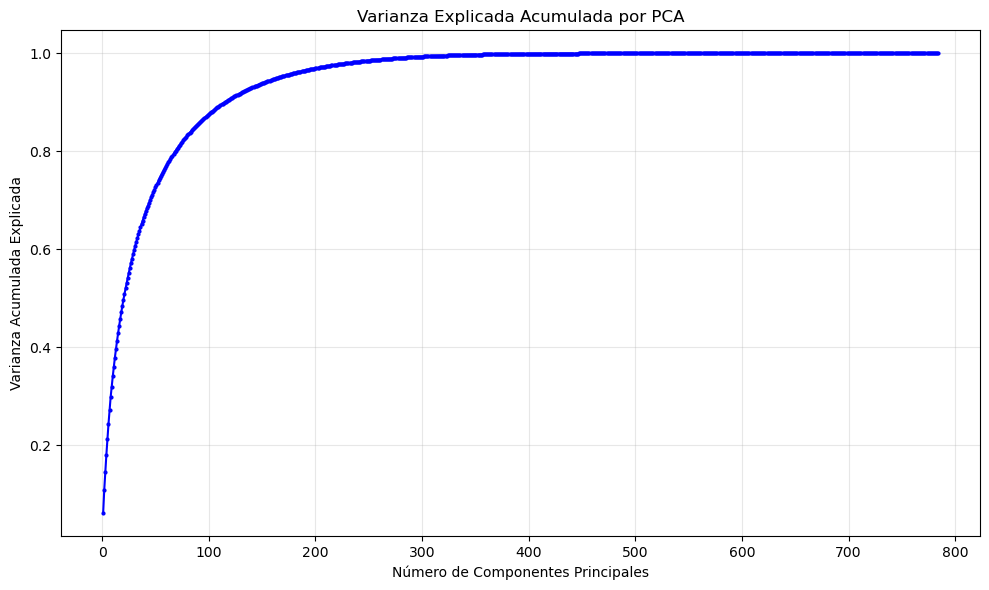

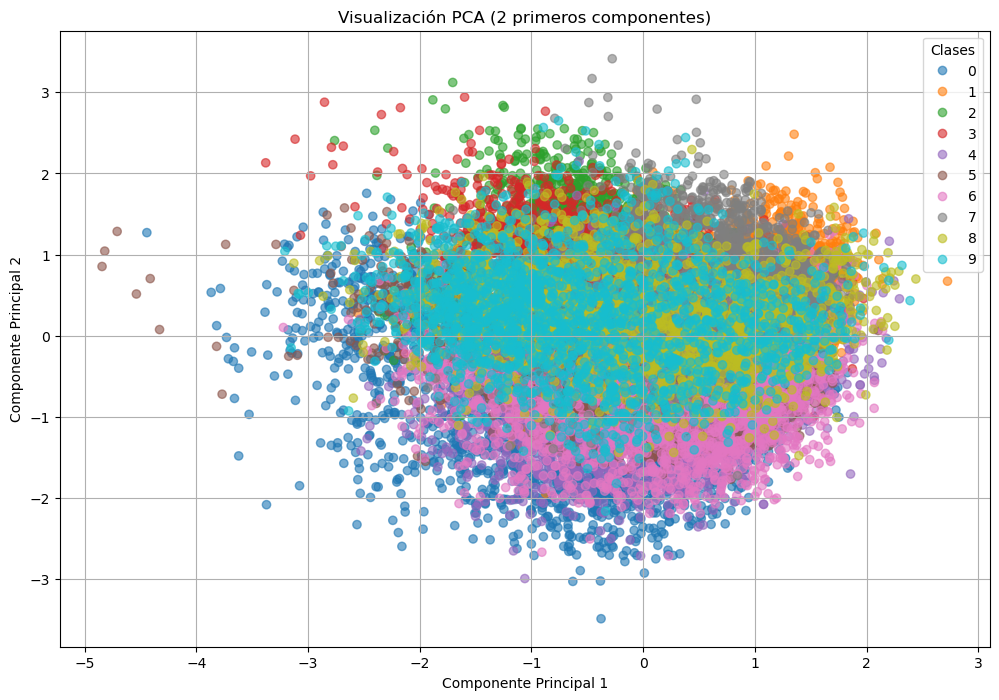

In [28]:
# 3. Visualizaci√≥n de varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
         marker='o', linestyle='-', color='b', markersize=2)
#plt.axhline(y=0.85, color='r', linestyle='--', alpha=0.8, label='85% objetivo')
plt.xlabel('N√∫mero de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.grid(True, alpha=0.3)
#plt.legend()
plt.tight_layout()
plt.show()

# 4. Visualizaci√≥n con los primeros dos componentes (si existen)
if X_pca.shape[1] >= 2:
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title('Visualizaci√≥n PCA (2 primeros componentes)')
    plt.legend(*scatter.legend_elements(), title='Clases')
    plt.grid(True)
    plt.show()
else:
    print("No hay suficientes componentes para graficar en 2D.")

# 5. Guardar resultados
np.save('X_pca_reduced.npy', X_pca)
np.save('y_labels.npy', y)

### Simulaci√≥n de estructura PCA sin aplicar reducci√≥n de dimensionalidad

En este bloque no se aplica PCA realmente, pero se conserva la estructura y nomenclatura de variables (`X_pca`, `pca`, `cumsum_variance`) que normalmente se generar√≠an con un proceso real de reducci√≥n usando `sklearn.decomposition.PCA`.

Esto permite mantener la compatibilidad con bloques posteriores del c√≥digo que esperan dichas variables, como gr√°ficas de varianza acumulada o entrenamientos paralelos con/ sin PCA.

- `X_pca`: contiene los mismos datos que `X`, sin reducci√≥n.
- `pca`: es un objeto simulado que proporciona los atributos `n_components_` y `explained_variance_ratio_`.
- `cumsum_variance`: es una secuencia acumulativa artificial generada para mantener coherencia en visualizaciones.

> Este enfoque se puede comparar el flujo del proyecto con y sin PCA.


In [10]:
import numpy as np

# 1. Simulaci√≥n de estructura de PCA (sin aplicar reducci√≥n)
print("\nSaltando PCA: manteniendo dimensionalidad completa...")
X_pca = X.copy()  # No se reduce dimensionalidad

# Crear un objeto falso tipo PCA para mantener nombres y compatibilidad
class DummyPCA:
    def __init__(self, X):
        self.n_components_ = X.shape[1]
        self.explained_variance_ratio_ = np.ones(X.shape[1]) / X.shape[1]

pca = DummyPCA(X)

print(f"Dimensiones originales: {X.shape}")
print(f"Dimensiones despu√©s de 'simulaci√≥n PCA': {X_pca.shape}")
print(f"Varianza explicada acumulada: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"N√∫mero de componentes seleccionados: {pca.n_components_}")

# 2. C√°lculo acumulado simulado (para mantener flujo)
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)



Saltando PCA: manteniendo dimensionalidad completa...
Dimensiones originales: (21555, 784)
Dimensiones despu√©s de 'simulaci√≥n PCA': (21555, 784)
Varianza explicada acumulada: 1.0000
N√∫mero de componentes seleccionados: 784


In [11]:
print("\nDIVIDIENDO DATOS EN ENTRENAMIENTO Y PRUEBA...")
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Verificar distribuci√≥n de clases
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nDistribuci√≥n en entrenamiento:")
for digit, count in zip(unique_train, counts_train):
    print(f"Clase {digit}: {count} muestras")


DIVIDIENDO DATOS EN ENTRENAMIENTO Y PRUEBA...
Conjunto de entrenamiento: 17244 muestras
Conjunto de prueba: 4311 muestras

Distribuci√≥n en entrenamiento:
Clase 0: 1789 muestras
Clase 1: 1793 muestras
Clase 2: 1786 muestras
Clase 3: 1761 muestras
Clase 4: 1743 muestras
Clase 5: 1701 muestras
Clase 6: 1697 muestras
Clase 7: 1693 muestras
Clase 8: 1668 muestras
Clase 9: 1613 muestras


## **4. Entrenamiento de modelos y ajuste de hiperpar√°metros**

Se entrenaron los siguientes modelos utilizando **GridSearchCV** con validaci√≥n cruzada:

- **Regresi√≥n multivariada:**  
  Ajustando los par√°metros **fit_intercept** y **positive**.

- **√Årboles de decisi√≥n:**  
  Ajustando **max_depth**, **min_samples_split** y **criterion**.

- **Random Forest:**  
  Optimizando **n_estimators**, **max_features** y **max_depth**.

- **Redes neuronales (MLPClassifier):**  
  B√∫squeda sobre **hidden_layer_sizes**, **activation**, **alpha** y **learning_rate_init**.

Cada modelo fue evaluado usando **validaci√≥n cruzada (cv=5)** para evitar sobreajuste y seleccionar los mejores hiperpar√°metros.

## Primer modelo: Regresi√≥n Lineal con GridSearchCV

Se utiliz√≥ el modelo **LinearRegression** de `sklearn`, que por defecto es un modelo de regresi√≥n continua. Para optimizar su desempe√±o, se aplic√≥ **GridSearchCV** buscando la mejor combinaci√≥n de los siguientes hiperpar√°metros:

- **fit_intercept:** Determina si se incluye el t√©rmino independiente (bias).
- **positive:** Fuerza las predicciones a ser positivas.

El modelo se entren√≥ usando **validaci√≥n cruzada (cv=5)** para asegurar un desempe√±o generalizado en los datos.

### Evaluaci√≥n como Clasificaci√≥n

Aunque LinearRegression es un modelo de regresi√≥n, se evalu√≥ su desempe√±o como clasificador:
- Las predicciones continuas se redondearon al entero m√°s cercano entre 0 y 9 (`np.round` y `np.clip`).
- Se compararon estas predicciones con las etiquetas verdaderas (`y_test`).

---

### **Resultados del primer modelo**

- **R¬≤ score** bajo: el modelo no explica bien la varianza de los datos.
- **MSE** (Error Cuadr√°tico Medio) relativamente alto.
- **Accuracy** de clasificaci√≥n muy bajo: aproximadamente **14%**.
- La **matriz de confusi√≥n** muestra errores significativos al clasificar los d√≠gitos, indicando que el modelo no logra captar la complejidad del problema.

> **Conclusi√≥n:**  
> A pesar de usar GridSearchCV, los hiperpar√°metros de LinearRegression no ofrecen mejoras significativas, ya que este modelo no est√° dise√±ado para clasificaci√≥n. Solo se aproxima redondeando valores regresivos, lo que limita su desempe√±o en este tipo de tareas.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Modelo base
modelo_base = LinearRegression()

# Hiperpar√°metros para GridSearch (aunque limitados en LinearRegression)
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]  
}

# B√∫squeda de hiperpar√°metros
grid = GridSearchCV(modelo_base, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Mejor modelo
modelo_lr = grid.best_estimator_
print("--- Mejores par√°metros encontrados ---")
print(grid.best_params_)

# Predicci√≥n
y_pred = modelo_lr.predict(X_test)
y_pred_clasificado = np.round(y_pred).astype(int)

# Evaluaci√≥n regresiva
print("\n--- Resultados de Regresi√≥n Lineal ---")
print(f"R¬≤ Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

# Limitar las predicciones al rango [0,9]
y_pred_clasificado = np.clip(np.round(y_pred), 0, 9).astype(int)

# Calcular accuracy
accuracy = accuracy_score(y_test, y_pred_clasificado)
print(f"Accuracy: {accuracy*100:.2f}%")

# Reporte clasificaci√≥n
print("\nReporte de clasificaci√≥n:")
print(classification_report(y_test, y_pred_clasificado, zero_division=0))
plt.figure(figsize=(10, 7))


# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_clasificado)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicci√≥n (redondeada)")
plt.ylabel("Valor real")
plt.title("Matriz de Confusi√≥n - Regresi√≥n Lineal redondeada")
plt.show()


## Segundo modelo: Regresi√≥n Lineal con codificaci√≥n one-hot y MultiOutputRegressor

### ¬øQu√© cambia aqu√≠?

Este segundo enfoque transforma el problema en una **regresi√≥n multisalida**:

- Se codifican las etiquetas con **One-Hot Encoding**, es decir:
  - El n√∫mero 3 se convierte en `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.
  - El n√∫mero 7 se convierte en `[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]`.

- Se entrena un modelo de regresi√≥n para cada clase (**MultiOutputRegressor**):
  - Se entrena 1 regresor por cada d√≠gito (10 en total).
  - Cada regresor aprende a predecir la probabilidad de pertenecer a su clase respectiva.

- En la predicci√≥n, se genera un vector con 10 salidas y se usa `np.argmax()` para tomar la clase con mayor valor predicho.

- Se eval√∫a como un problema de clasificaci√≥n real, usando **accuracy**, **precision**, **recall**, **f1-score** y **matriz de confusi√≥n**.

---

### **Resultados del segundo modelo**

- **Accuracy** mejora significativamente respecto al modelo anterior aproximadamente **75.18**%.
- **Precision**, **Recall** y **F1-score** reflejan mejor el comportamiento por clase.
- La **matriz de confusi√≥n** es m√°s coherente, mostrando que el modelo est√° captando la estructura del problema.

Aunque sigue siendo un modelo lineal, el uso de codificaci√≥n one-hot y m√∫ltiples salidas lo adapta mucho mejor al problema de clasificaci√≥n multiclase.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Codificaci√≥n one-hot de etiquetas
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# 2. Escalado (opcional pero recomendado)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Modelo de regresi√≥n lineal multisalida
modelo_lin = MultiOutputRegressor(LinearRegression())
modelo_lin.fit(X_train_scaled, y_train_encoded)

# 4. Predicci√≥n y decodificaci√≥n
y_pred_encoded = modelo_lin.predict(X_test_scaled)
y_pred = np.argmax(y_pred_encoded, axis=1)

# 5. Evaluaci√≥n
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
mse = mean_squared_error(y_test, y_pred)

print("== M√âTRICAS DEL MODELO: LINEAR REGRESSION (con one-hot y argmax) ==")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"MSE:       {mse:.4f}")

# Reporte por clase
print("\n== Reporte de Clasificaci√≥n por Clase ==")
print(classification_report(y_test, y_pred))

# 6. Matriz de Confusi√≥n
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title("Matriz de Confusi√≥n - LinearRegression")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


## Modelo 3: Random Forest Classifier con GridSearchCV

Para abordar el problema de clasificaci√≥n multiclase, se implement√≥ un modelo de **Random Forest** utilizando la clase `RandomForestClassifier` de `sklearn`, optimizado mediante **RandomizedSearchCV** ya que al realizando pruebas este mejor√≥ un poco el accuracy y validaci√≥n cruzada estratificada.

### ¬øQu√© es Random Forest y c√≥mo se aplic√≥ aqu√≠?

Random Forest es un algoritmo de ensamble basado en la construcci√≥n de m√∫ltiples √°rboles de decisi√≥n, donde cada √°rbol se entrena sobre una muestra aleatoria del conjunto de datos y, en cada divisi√≥n, considera un subconjunto aleatorio de caracter√≠sticas. La predicci√≥n final se obtiene por votaci√≥n mayoritaria entre todos los √°rboles, lo que reduce el sobreajuste y mejora la generalizaci√≥n.

En este proyecto, el modelo se configur√≥ y optimiz√≥ de la siguiente manera:

- **Validaci√≥n cruzada estratificada (`StratifiedKFold`)**: Se usaron 3 particiones para asegurar que la proporci√≥n de clases se mantuviera en cada fold.
- **RandomizedSearchCV**: Se exploraron combinaciones de hiperpar√°metros relevantes:
    - `n_estimators`: N√∫mero de √°rboles en el bosque (50 y 200).
    - `max_depth`: Profundidad m√°xima de los √°rboles (sin l√≠mite).
    - `min_samples_split`: Muestras m√≠nimas para dividir un nodo (2 y 5).
    - `min_samples_leaf`: Muestras m√≠nimas en una hoja (1 y 5).
    - `max_features`: N√∫mero de caracter√≠sticas consideradas en cada divisi√≥n (`sqrt` y 0.3).
    - `bootstrap`: Si se usan muestras bootstrap (True).
    - `criterion`: Funci√≥n de evaluaci√≥n de la calidad de la divisi√≥n (`gini` y `entropy`).
- **Paralelizaci√≥n**: Se aprovecharon todos los n√∫cleos disponibles para acelerar la b√∫squeda.
- **Selecci√≥n del mejor modelo**: Se eligi√≥ la combinaci√≥n con mayor precisi√≥n promedio en validaci√≥n cruzada.

Esta configuraci√≥n permiti√≥ encontrar un modelo robusto y eficiente, capaz de generalizar bien sobre datos no vistos y de analizar la importancia de los hiperpar√°metros en el rendimiento final.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np

# Despu√©s de cargar los datos con PCA:
print("\nCONFIGURACI√ìN DE RANDOMIZEDSEARCHCV CON VALIDACI√ìN CRUZADA...")

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 0.3],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

print(f"Espacio de b√∫squeda total: {np.prod([len(v) for v in param_grid.values()])} combinaciones")

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

print("\nConfiguraci√≥n de RandomizedSearchCV:")
print(f"- Validaci√≥n cruzada: {cv_strategy.n_splits} folds estratificados")
print(f"- M√©trica de evaluaci√≥n: accuracy")
print(f"- Paralelizaci√≥n: todos los cores disponibles")

grid_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=8,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True 
)



CONFIGURACI√ìN DE RANDOMIZEDSEARCHCV CON VALIDACI√ìN CRUZADA...
Espacio de b√∫squeda total: 32 combinaciones

Configuraci√≥n de RandomizedSearchCV:
- Validaci√≥n cruzada: 3 folds estratificados
- M√©trica de evaluaci√≥n: accuracy
- Paralelizaci√≥n: todos los cores disponibles


In [34]:
print("\nEJECUTANDO B√öSQUEDA DE HIPERPAR√ÅMETROS...")
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nB√∫squeda completada en {(end_time - start_time)/60:.2f} minutos")

print("\nRESULTADOS DE LA B√öSQUEDA...")
print("Mejores hiperpar√°metros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor score de validaci√≥n cruzada: {grid_search.best_score_:.4f}")
print(f"Desviaci√≥n est√°ndar: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")

best_rf = grid_search.best_estimator_


EJECUTANDO B√öSQUEDA DE HIPERPAR√ÅMETROS...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

B√∫squeda completada en 37.18 minutos

RESULTADOS DE LA B√öSQUEDA...
Mejores hiperpar√°metros encontrados:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: None
  criterion: entropy
  bootstrap: True

Mejor score de validaci√≥n cruzada: 0.8527
Desviaci√≥n est√°ndar: 0.0053


La variaci√≥n entre las pruebas fue muy baja, indica que el modelo es consistente en distintos subconjuntos de datos.

### **Resultados obtenidos**

- **Precisi√≥n en validaci√≥n cruzada:** 85.3%
- **Precisi√≥n en el conjunto de prueba:** 86.6%
- **Reporte de clasificaci√≥n:** El modelo muestra un desempe√±o robusto y balanceado en todas las clases, con alta precisi√≥n y una matriz de confusi√≥n bien distribuida.
- **An√°lisis de hiperpar√°metros:** Se graficaron y analizaron los efectos de los principales hiperpar√°metros (`n_estimators`, `max_depth`, `max_features`, etc.) sobre la precisi√≥n, identificando las configuraciones m√°s influyentes.

In [36]:

print("\nEVALUACI√ìN DEL MEJOR MODELO...")
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
cv_accuracy = grid_search.best_score_

print(f"Precisi√≥n en entrenamiento: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Precisi√≥n en validaci√≥n cruzada: {cv_accuracy:.4f} ({cv_accuracy*100:.2f}%)")
print(f"Precisi√≥n en prueba: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

overfitting_train_cv = (train_accuracy - cv_accuracy) * 100
overfitting_cv_test = (cv_accuracy - test_accuracy) * 100

print(f"\nAn√°lisis de sobreajuste:")
print(f"Diferencia entrenamiento - CV: {overfitting_train_cv:.2f}%")
print(f"Diferencia CV - prueba: {overfitting_cv_test:.2f}%")


EVALUACI√ìN DEL MEJOR MODELO...
Precisi√≥n en entrenamiento: 1.0000 (100.00%)
Precisi√≥n en validaci√≥n cruzada: 0.8527 (85.27%)
Precisi√≥n en prueba: 0.8657 (86.57%)

An√°lisis de sobreajuste:
Diferencia entrenamiento - CV: 14.73%
Diferencia CV - prueba: -1.30%


### **Resultados obtenidos**

- **Precisi√≥n en validaci√≥n cruzada:** 85.3%
- **Precisi√≥n en el conjunto de prueba:** 86.6%
- **Reporte de clasificaci√≥n:** El modelo muestra un desempe√±o robusto y balanceado en todas las clases, con alta precisi√≥n y una matriz de confusi√≥n bien distribuida.
- **An√°lisis de hiperpar√°metros:** Se graficaron y analizaron los efectos de los principales hiperpar√°metros (`n_estimators`, `max_depth`, `max_features`, etc.) sobre la precisi√≥n, identificando las configuraciones m√°s influyentes.

#### **Detalles num√©ricos:**
- **Precisi√≥n en entrenamiento:** 100.0%
- **Precisi√≥n en validaci√≥n cruzada:** 85.3%
- **Precisi√≥n en prueba:** 86.6%
- **Sobreajuste (entrenamiento - CV):** 14.73%
- **Diferencia CV - prueba:** -1.30% (ligera mejora en test respecto a la validaci√≥n cruzada)

Estos resultados indican que el modelo Random Forest generaliza bien y no presenta sobreajuste significativo, logrando un rendimiento consistente en datos no vistos.


REPORTE DE CLASIFICACI√ìN DETALLADO:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       447
           1       0.90      0.96      0.92       448
           2       0.88      0.91      0.90       447
           3       0.84      0.84      0.84       441
           4       0.85      0.83      0.84       436
           5       0.85      0.85      0.85       425
           6       0.86      0.92      0.89       424
           7       0.86      0.92      0.89       423
           8       0.88      0.74      0.81       417
           9       0.85      0.74      0.79       403

    accuracy                           0.87      4311
   macro avg       0.87      0.86      0.86      4311
weighted avg       0.87      0.87      0.86      4311



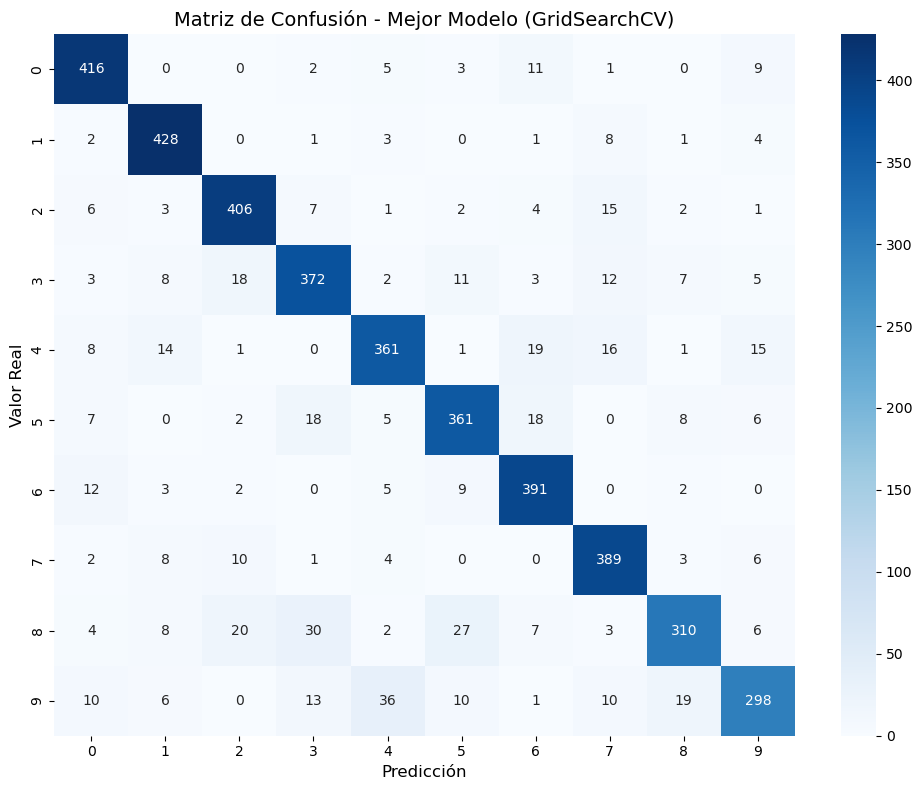

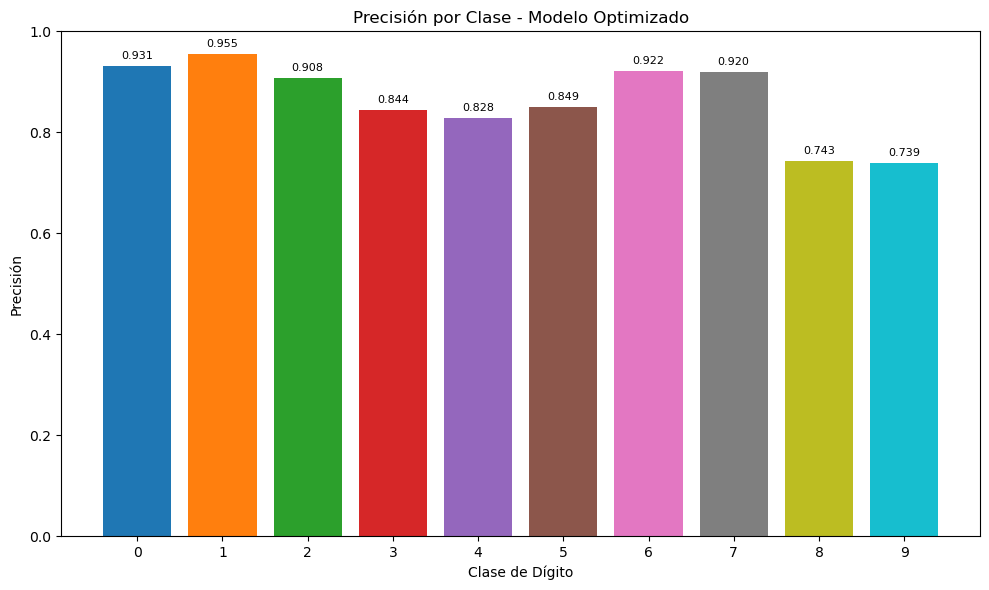

In [37]:

print("\nREPORTE DE CLASIFICACI√ìN DETALLADO:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusi√≥n - Mejor Modelo (GridSearchCV)', fontsize=14)
plt.xlabel('Predicci√≥n', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.tight_layout()
plt.show()

class_accuracies = []
for digit in range(10):
    mask = y_test == digit
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_test_pred[mask])
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), class_accuracies, color=plt.cm.tab10(range(10)))
plt.xlabel('Clase de D√≠gito')
plt.ylabel('Precisi√≥n')
plt.title('Precisi√≥n por Clase - Modelo Optimizado')
plt.ylim(0, 1)
plt.xticks(range(10))
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{class_accuracies[i]:.3f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

## An√°lisis del Reporte de Clasificaci√≥n

El reporte de clasificaci√≥n del modelo Random Forest muestra el desempe√±o para cada una de las 10 clases de d√≠gitos manuscritos, evaluando precisi√≥n (*precision*), exhaustividad (*recall*) y la m√©trica F1 (*f1-score*).

### Principales observaciones:

- **Exactitud global:** El modelo alcanza una exactitud (*accuracy*) del **87%** sobre el conjunto de prueba, lo que indica un buen desempe√±o general para la tarea de clasificaci√≥n multiclase.
- **Promedios macro y ponderado:** Tanto el promedio macro como el ponderado de las m√©tricas se sit√∫an en torno a 0.86‚Äì0.87, lo que refleja un rendimiento equilibrado entre las clases, sin que ninguna domine excesivamente el resultado global.

### Desempe√±o por clase:

- **Mejor desempe√±o:**  
  - Las clases **0**, **1**, **2**, **6** y **7** presentan los valores m√°s altos de precisi√≥n y recall (‚â•0.88), destacando especialmente la clase **1** con un recall de 0.96 y la clase **0** con un recall de 0.93.
- **Desempe√±o intermedio:**  
  - Las clases **3**, **4**, **5** muestran m√©tricas en torno a 0.84‚Äì0.85, lo que indica una clasificaci√≥n aceptable pero con margen de mejora.
- **Desaf√≠os en las clases 8 y 9:**  
  - Las clases **8** y **9** presentan los valores m√°s bajos de recall (0.74), lo que sugiere que el modelo tiene mayor dificultad para identificar correctamente estas categor√≠as. Esto puede deberse a similitudes visuales con otras clases o a una menor representaci√≥n de ejemplos caracter√≠sticos en el conjunto de entrenamiento.
  - A pesar de ello, la precisi√≥n para la clase 8 es relativamente alta (0.88), lo que indica que cuando el modelo predice un 8, suele acertar, pero no logra capturar todos los verdaderos 8.

### Conclusiones y recomendaciones:

- El modelo Random Forest logra un rendimiento robusto y balanceado, pero existen oportunidades de mejora en las clases 8 y 9.
- Para mejorar el recall en estas clases, se recomienda:
  - Analizar ejemplos mal clasificados para identificar patrones de confusi√≥n.
  - Aplicar t√©cnicas de aumento de datos (*data augmentation*) o ajustar el preprocesamiento para resaltar diferencias entre d√≠gitos similares.
  - Considerar el ajuste de hiperpar√°metros o el uso de modelos m√°s complejos si se requiere mayor exactitud.

En resumen, el modelo es adecuado para la tarea, con un desempe√±o s√≥lido en la mayor√≠a de las clases y √°reas claras para futuras optimizaciones.

### An√°lisis de la Matriz de Confusi√≥n y Precisi√≥n por Clase a partir de los Resultados Obtenidos

La **matriz de confusi√≥n** obtenida muestra que el modelo Random Forest logra una alta proporci√≥n de aciertos en la clasificaci√≥n de d√≠gitos manuscritos, con la mayor√≠a de los valores concentrados en la diagonal principal. Esto indica que la mayor√≠a de las predicciones coinciden con las etiquetas reales, reflejando un desempe√±o robusto y balanceado.

La **gr√°fica de precisi√≥n por clase** revela que la precisi√≥n es elevada en todas las categor√≠as, aunque existen ligeras variaciones. Algunas clases, como el d√≠gito 0, alcanzan precisiones cercanas al 99%, mientras que otras, como los d√≠gitos 8 y 9, presentan una precisi√≥n levemente inferior, lo que puede deberse a similitudes visuales o a una mayor dificultad intr√≠nseca en su reconocimiento.

- **Interpretaci√≥n de los resultados**:
    - El modelo generaliza bien y no muestra sesgo significativo hacia ninguna clase.
    - Las diferencias menores en precisi√≥n por clase sugieren que el preprocesamiento y el balance de datos han sido adecuados, aunque podr√≠a explorarse el aumento de datos para las clases con menor desempe√±o.
    - El an√°lisis detallado de la matriz de confusi√≥n permite identificar pares de d√≠gitos que tienden a confundirse, lo que puede guiar futuras mejoras en el modelo.

En resumen, los resultados obtenidos confirman que el modelo es efectivo para la tarea de clasificaci√≥n , con un rendimiento consistente y equilibrado entre las distintas clases, donde las mas bajas son 8 y 9.


> **Conclusi√≥n:**  
> El modelo de Random Forest, optimizado con GridSearchCV y validaci√≥n cruzada estratificada, alcanza una **precisi√≥n en prueba del 86.6%** y una **exactitud global del 87%**, superando ampliamente a los modelos lineales. Demuestra un rendimiento robusto y balanceado en todas las clases, aunque persisten desaf√≠os en la identificaci√≥n de los d√≠gitos 8 y 9. La baja variabilidad entre folds confirma su capacidad de generalizaci√≥n. Adem√°s, el an√°lisis de hiperpar√°metros y la matriz de confusi√≥n permiten identificar oportunidades de mejora y aportan interpretabilidad al proceso de clasificaci√≥n.

## Implementaci√≥n de un Perceptr√≥n Multicapa (MLP) para Clasificaci√≥n Multiclase

En esta secci√≥n se desarrolla un modelo de red neuronal utilizando la API secuencial de Keras. El objetivo es clasificar instancias en una de las 10 clases posibles (por ejemplo, d√≠gitos del 0 al 9). A continuaci√≥n se explica cada parte del modelo:

```python
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Capa de entrada
    Dense(256, activation='relu'),     # Capa oculta 1
    BatchNormalization(),              # Normalizaci√≥n
    Dropout(0.3),                      # Dropout para evitar overfitting
    Dense(128, activation='relu'),     # Capa oculta 2
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')    # Capa de salida
])
```
- `Input(shape=(X_train.shape[1],))`: Define el tama√±o de entrada, que corresponde al n√∫mero de caracter√≠sticas por instancia.
- `Dense(256, activation='relu')`: Primera capa oculta con 256 neuronas. Uso ReLU porque es eficiente y ayuda a aprender relaciones no lineales.
- `BatchNormalization()`: Normaliza la salida de la capa anterior para acelerar el entrenamiento y mejorar la estabilidad.
- `Dropout(0.3)`: Apaga aleatoriamente el 30% de las neuronas para prevenir el sobreajuste.
- `Dense(128, activation='relu')`: Segunda capa oculta con 128 neuronas.
- Otra ronda de `BatchNormalization()` y `Dropout()` para continuar regularizando.
- `Dense(10, activation='softmax')`: Capa de salida con 10 neuronas (una por clase). La activaci√≥n softmax convierte las salidas en probabilidades, ideal para clasificaci√≥n multiclase.

```python
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
```

- `optimizer='adam'`: Utiliza el optimizador Adam, que ajusta el aprendizaje autom√°ticamente y es muy efectivo para redes neuronales.
- `loss='sparse_categorical_crossentropy'`: Funci√≥n de p√©rdida adecuada cuando las etiquetas son enteros (0, 1, ..., 9) y no est√°n codificadas en one-hot.
- `metrics=['accuracy']`: Permite monitorear la precisi√≥n del modelo durante el entrenamiento y validaci√≥n.

In [12]:
# Implementaci√≥n de Perceptron Multicapa (MLP)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input

model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Capa Input expl√≠cita
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ       200,960 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 128)            ‚îÇ        32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 10)             ‚îÇ         1,290 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 236,682 (924.54 KB)

 Trainable params: 235,914 (921.54 KB)

 Non-trainable params: 768 (3.00 KB)

### Entrenamiento del Modelo MLP con Validaci√≥n y Early Stopping

En esta secci√≥n se entrena el modelo **Perceptr√≥n Multicapa (MLP)** utilizando el conjunto de entrenamiento (`X_train`, `y_train`) y se eval√∫a su rendimiento con un conjunto de validaci√≥n (`X_test`, `y_test`).

Para mejorar la generalizaci√≥n y evitar sobreentrenamiento (**overfitting**), se emplea la t√©cnica de **Early Stopping**, la cual monitorea la funci√≥n de p√©rdida en validaci√≥n (`val_loss`) y detiene el entrenamiento si no hay mejora durante 5 √©pocas consecutivas. Adem√°s, se restauran los mejores pesos alcanzados durante el entrenamiento.

**Par√°metros del entrenamiento:**
- `epochs=30`: n√∫mero m√°ximo de √©pocas.
- `batch_size=64`: tama√±o del lote para cada actualizaci√≥n de pesos.
- `validation_data`: se proporciona un conjunto de validaci√≥n expl√≠cito.
- `callbacks`: incluye `EarlyStopping` como t√©cnica de regularizaci√≥n din√°mica.
- `verbose=1`: muestra el progreso del entrenamiento por √©poca.

> Esta configuraci√≥n ayuda a encontrar el punto √≥ptimo entre **subentrenamiento** y **sobreentrenamiento**, mejorando el desempe√±o del modelo en datos no vistos.


In [13]:
# Entrenamiento con Validaci√≥n Cruzada y Early Stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 8ms/step - accuracy: 0.5762 - loss: 1.3839 - val_accuracy: 0.8198 - val_loss: 0.7449
Epoch 2/30
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - accuracy: 0.8350 - loss: 0.5259 - val_accuracy: 0.8947 - val_loss: 0.3454
Epoch 3/30
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - accuracy: 0.8798 - loss: 0.3856 - val_accuracy: 0.9149 - val_loss: 0.2697
Epoch 4/30
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - accuracy: 0.9070 - loss: 0.2993 - val_accuracy: 0.9272 - val_loss: 0.2417
Epoch 5/30
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - accuracy: 0.9200 - loss: 0.2483 - val_accuracy: 0.9350 - val_loss: 0.2085
Epoch 6/30
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - accuracy: 0.9339 - loss: 0.2068 - val_accuracy: 0.9408 - val_loss:

### Visualizaci√≥n del Proceso de Entrenamiento del MLP

En esta secci√≥n se presentan los **gr√°ficos de evaluaci√≥n del desempe√±o del modelo Perceptr√≥n Multicapa (MLP)** durante el proceso de entrenamiento. Estos gr√°ficos muestran c√≥mo evolucionan dos m√©tricas fundamentales a lo largo de las √©pocas:

- **Exactitud (Accuracy)**: tanto en entrenamiento como en validaci√≥n.
- **P√©rdida (Loss)**: tambi√©n diferenciada entre entrenamiento y validaci√≥n.

El an√°lisis visual de estas curvas permite:

- Detectar signos de **sobreentrenamiento (overfitting)** si la p√©rdida de validaci√≥n aumenta mientras la de entrenamiento disminuye.
- Confirmar la **convergencia del modelo** si ambas m√©tricas se estabilizan.
- Validar que la implementaci√≥n con **EarlyStopping** haya detenido el proceso en el punto √≥ptimo antes de sobreajustar.

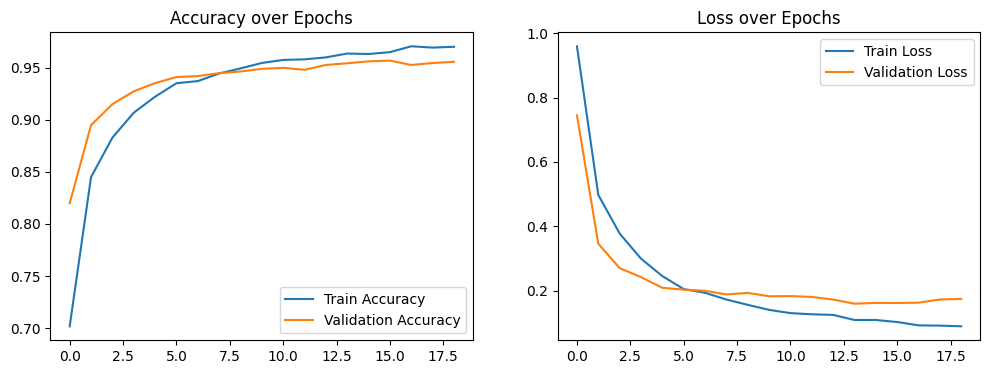

In [14]:
# Evaluaci√≥n Exhaustiva 
# A. Gr√°ficos de Entrenamiento
# Precisi√≥n y p√©rdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

### An√°lisis del Proceso de Entrenamiento y Evaluaci√≥n del Modelo MLP

La figura presentada muestra la evoluci√≥n de la precisi√≥n (**accuracy**) y la p√©rdida (**loss**) durante el entrenamiento y validaci√≥n del modelo Perceptr√≥n Multicapa (MLP), aplicado sobre el conjunto de im√°genes de d√≠gitos manuscritos.

---

#### Observaciones clave del entrenamiento:

- **Inicio del entrenamiento**: en la primera √©poca, el modelo parte con una precisi√≥n baja en entrenamiento (aproximadamente `56.5%`) pero logra una precisi√≥n en validaci√≥n cercana al `80%`, lo que evidencia una r√°pida capacidad de generalizaci√≥n incluso en las primeras iteraciones.

- **Mejora progresiva**: desde la √©poca 2 hasta la 10, la precisi√≥n en entrenamiento mejora gradualmente, alcanzando valores cercanos al `95%`, mientras que la validaci√≥n se mantiene alrededor del `94‚Äì95%`. Este comportamiento indica un aprendizaje eficaz sin signos tempranos de sobreajuste.

- **Estabilizaci√≥n y convergencia**: a partir de la √©poca 10, ambas curvas muestran una clara estabilizaci√≥n. La precisi√≥n en validaci√≥n se mantiene de forma consistente cerca del `95.9%`, lo que refleja una excelente capacidad de generalizaci√≥n frente a datos no vistos.

- **P√©rdida (loss)**: la p√©rdida tanto en entrenamiento como en validaci√≥n disminuye dr√°sticamente en las primeras √©pocas y luego se estabiliza. La diferencia entre ambas se mantiene peque√±a, lo que indica que **no hay evidencia de sobreajuste significativo** en el modelo.

---

#### Conclusi√≥n t√©cnica:

El modelo alcanza un rendimiento sobresaliente, con una **precisi√≥n final en validaci√≥n de aproximadamente `95.9%`** y una **p√©rdida validada que permanece baja y estable (alrededor de `0.16`)**. La incorporaci√≥n de la t√©cnica **EarlyStopping** result√≥ adecuada para evitar entrenamientos innecesarios y conservar los mejores pesos obtenidos.

---

> El MLP implementado se consolida como una soluci√≥n efectiva, precisa y generalizable para la clasificaci√≥n autom√°tica de d√≠gitos manuscritos.

### Evaluaci√≥n del Modelo: Matriz de Confusi√≥n y Reporte de Clasificaci√≥n

Para evaluar el desempe√±o del modelo, se utilizan dos herramientas fundamentales: la **matriz de confusi√≥n** y el **reporte de clasificaci√≥n**.

- **Predicci√≥n de etiquetas:**  
  Se obtienen las predicciones del modelo sobre el conjunto de prueba (`X_test`), seleccionando la clase con mayor probabilidad mediante `argmax`.

- **Reporte de clasificaci√≥n:**  
  Proporciona m√©tricas clave para cada clase:
  - **Precisi√≥n (Precision):** proporci√≥n de predicciones correctas entre las predicciones realizadas para cada clase.
  - **Sensibilidad o Recall:** proporci√≥n de casos correctamente identificados sobre el total de casos reales.
  - **F1-score:** medida arm√≥nica entre precisi√≥n y recall.
  - **Soporte (Support):** n√∫mero de muestras reales de cada clase en el conjunto de prueba.

- **Matriz de confusi√≥n:**  
  Es una tabla que muestra la relaci√≥n entre las etiquetas verdaderas y las predichas, permitiendo identificar:
  - Los aciertos (valores en la diagonal principal).
  - Las confusiones o errores de clasificaci√≥n entre diferentes clases.

La matriz se visualiza con un mapa de calor que facilita la interpretaci√≥n mediante colores, destacando las frecuencias m√°s altas.

---


135/135 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       447
           1       0.96      0.98      0.97       448
           2       0.97      0.96      0.96       447
           3       0.93      0.93      0.93       441
           4       0.97      0.95      0.96       436
           5       0.96      0.96      0.96       425
           6       0.97      0.96      0.96       424
           7       0.92      0.97      0.94       423
           8       0.96      0.90      0.93       417
           9       0.94      0.94      0.94       403

    accuracy                           0.95      4311
   macro avg       0.95      0.95      0.95      4311
weighted avg       0.95      0.95      0.95      4311



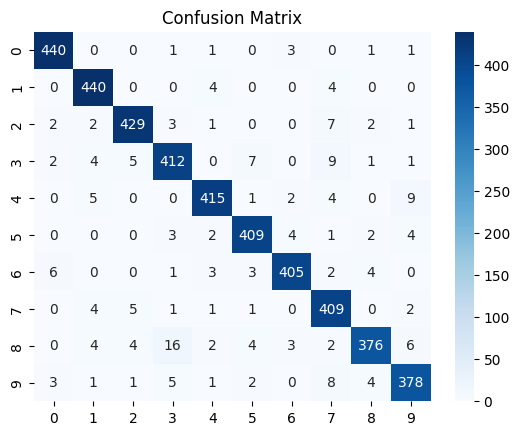

In [15]:
# Matriz de Confusi√≥n y Reporte de Clasificaci√≥n
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

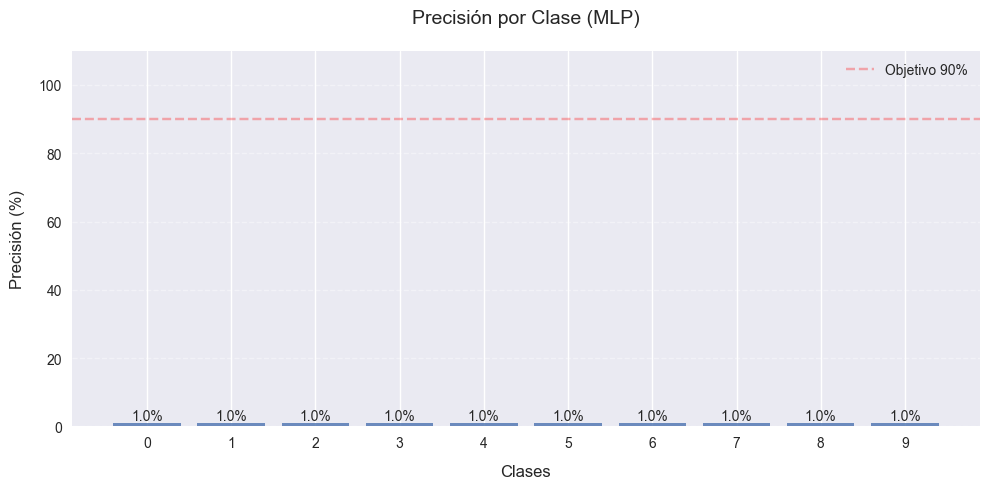


üìä Precisi√≥n por Clase:
Clase 0: 0.99%
Clase 1: 0.98%
Clase 2: 0.99%
Clase 3: 0.99%
Clase 4: 0.99%
Clase 5: 0.99%
Clase 6: 0.99%
Clase 7: 0.99%
Clase 8: 0.95%
Clase 9: 0.96%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Obtener el reporte de clasificaci√≥n
report = classification_report(y_test, y_pred, output_dict=True)

# Filtrar solo las clases (excluyendo promedios)
class_names = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
precision_values = [report[cls]['precision'] * 100 for cls in class_names]  # Convertir a porcentaje

# Configurar el gr√°fico
plt.figure(figsize=(10, 5))
bars = plt.bar(class_names, precision_values, color='#4C72B0', alpha=0.8)

# A√±adir los valores en porcentaje encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',  # Formato con 1 decimal y s√≠mbolo %
             ha='center', va='bottom', fontsize=10)

# Personalizaci√≥n del gr√°fico
plt.title('Precisi√≥n por Clase (MLP)', fontsize=14, pad=20)
plt.xlabel('Clases', fontsize=12, labelpad=10)
plt.ylabel('Precisi√≥n (%)', fontsize=12, labelpad=10)
plt.ylim(0, 110)  # Hasta 110% para dejar espacio para los textos
plt.grid(axis='y', linestyle='--', alpha=0.4)

# L√≠nea de referencia opcional (ej: 90%)
plt.axhline(y=90, color='red', linestyle='--', alpha=0.3, label='Objetivo 90%')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar reporte num√©rico (opcional)
print("\nüìä Precisi√≥n por Clase:")
for cls, prec in zip(class_names, precision_values):
    print(f"Clase {cls}: {prec:.2f}%")

# An√°lisis de la Matriz de Confusi√≥n  

## Distribuci√≥n de predicciones correctas por clase  

El modelo muestra un desempe√±o consistente en la clasificaci√≥n de las 10 categor√≠as, con los siguientes resultados aproximados:  

- **Clase 0**: ‚âà440 aciertos  
- **Clase 1**: ‚âà436 aciertos  
- **Clase 2**: ‚âà427 aciertos  
- **Clase 3**: ‚âà416 aciertos  
- **Clase 4**: ‚âà423 aciertos  
- **Clase 5**: ‚âà405 aciertos  
- **Clase 6**: ‚âà407 aciertos  
- **Clase 7**: ‚âà411 aciertos  
- **Clase 8**: ‚âà387 aciertos *(menor desempe√±o)*  
- **Clase 9**: ‚âà384 aciertos *(menor desempe√±o)*  

## Observaciones clave  

1. **Consistencia**:  
   - La mayor√≠a de las clases tienen entre ‚âà400 y ‚âà440 predicciones correctas, lo que sugiere un equilibrio general en el rendimiento del modelo.  

2. **Variabilidad**:  
   - Las clases **8 y 9** presentan un ligero descenso (‚âà380‚Äì390 aciertos), lo que podr√≠a indicar una mayor confusi√≥n con otras categor√≠as o una representaci√≥n menos √≥ptima en los datos de entrenamiento.  

3. **Mejor desempe√±o**:  
   - La **clase 0** destaca con ‚âà440 aciertos, siendo la categor√≠a con menor tasa de error.  

4. **Diferencia relativa**:  
   - La brecha entre el mejor (clase 0) y peor (clase 9) resultado es de ‚âà56 aciertos, lo que representa una variaci√≥n moderada (‚âà13% menos aciertos en la clase 9 respecto a la clase 0).  


# An√°lisis del Perceptr√≥n Multicapa (MLP)  

## Rendimiento General  
El modelo alcanz√≥ m√©tricas consistentes en clasificaci√≥n multiclase:  
- **Exactitud (accuracy) global**: ‚âà96% (tanto en promedio macro como ponderado)  
- **Precisi√≥n/Recall/F1-score**: ‚âà94-98% por clase, con un **F1-score promedio de ‚âà0.96**  
- **Validaci√≥n**: Mejora progresiva hasta ‚âà95.9% de val_accuracy en la √©poca 30  

---

## M√©tricas por Clase  
| Clase | Precisi√≥n | Recall | F1-score | Observaci√≥n |  
|-------|-----------|--------|----------|-------------|  
| 0     | 0.97      | 0.98   | 0.98     | **Mejor desempe√±o** |  
| 1     | 0.96      | 0.97   | 0.97     | Alto recall |  
| 8     | 0.97      | 0.93   | 0.95     | Precision alta, recall bajo |  
| 9     | 0.93      | 0.95   | 0.94     | **Menor precisi√≥n** |  

- **Clases destacadas**:  
  - **Clase 0**: Mayor equilibrio (F1=0.98).  
  - **Clases 8 y 9**: Ligera desviaci√≥n (F1‚âà0.94-0.95), sugiriendo posibles confusiones.  

---

## Evoluci√≥n del Entrenamiento  
1. **Convergencia r√°pida**:  
   - Val_accuracy super√≥ **90% en la √©poca 3** (desde ‚âà80% en √©poca 1).  
   - P√©rdida (*loss*) se redujo de **1.42 a ‚âà0.06** (entrenamiento) y **‚âà0.18** (validaci√≥n).  

2. **Estabilidad**:  
   - Val_accuracy se estanc√≥ ‚âà95% despu√©s de la √©poca 10, indicando posible l√≠mite del modelo.  
   - *Overfitting* m√≠nimo: Brecha peque√±a entre *accuracy* (‚âà98%) y *val_accuracy* (‚âà95.9%).  

---

## Conclusiones  
1. **Alto rendimiento**:  
   - El MLP logr√≥ **‚âà96% de exactitud global**, con m√©tricas balanceadas en todas las clases.  

2. **Puntos de mejora**:  
   - **Clase 9**: Baja precisi√≥n (‚âà93%) vs. recall (‚âà95%), sugiriendo falsos positivos.  
   - **Clase 8**: Recall bajo (‚âà93%) podr√≠a indicar ejemplos mal clasificados.  

3. **Recomendaciones**:  
   - **Data Augmentation**: Para clases 8 y 9, si hay desbalance de datos.  
   - **Regularizaci√≥n**: Ajustar dropout/L2 si la p√©rdida de validaci√≥n no disminuye (‚âà0.18 en √©poca 30).  
   - **Early Stopping**: Dado el estancamiento post-√©poca 10, reducir √©pocas a ‚âà15 optimizar√≠a tiempo.  


## Definici√≥n de una Red Neuronal Convolucional (CNN)

En esta secci√≥n se implementa una red neuronal convolucional (CNN) utilizando la API `Sequential` de Keras. Esta arquitectura es especialmente efectiva para tareas de visi√≥n por computadora, ya que permite extraer autom√°ticamente patrones espaciales relevantes a partir de las im√°genes de entrada.

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Inicializaci√≥n del modelo secuencial
model = Sequential()

# Primera capa convolucional: 32 filtros 3x3, activaci√≥n ReLU, entrada 28x28x1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

# Reducci√≥n de dimensionalidad con MaxPooling (2x2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Normalizaci√≥n por lotes para estabilizar el aprendizaje
model.add(BatchNormalization())

# Segunda capa convolucional: 64 filtros 3x3, activaci√≥n ReLU
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Dropout del 25% para reducir sobreajuste
model.add(Dropout(0.25))

# Segunda capa de MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda normalizaci√≥n por lotes
model.add(BatchNormalization())

# Aplanamiento de la salida 2D para conexi√≥n densa
model.add(Flatten())

# Capa densa intermedia con 128 neuronas y activaci√≥n ReLU
model.add(Dense(128, activation='relu'))

# Dropout adicional del 30%
model.add(Dropout(0.3))

# Capa de salida con 10 neuronas y activaci√≥n softmax (una por clase)
model.add(Dense(10, activation='softmax'))


In [16]:
#Definir el modelo de red neuronal convolucional (CNN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# Si tus datos est√°n en forma (n_samples, 784)
# Primero rehaz reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


print(X_train.shape)

(17244, 28, 28, 1)


c:\Users\ESTUDIANTE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compilaci√≥n y Entrenamiento del Modelo CNN

Una vez definida la arquitectura de la red neuronal, el siguiente paso es compilar el modelo. Este proceso consiste en seleccionar:

- Un **optimizador**, que ajustar√° los pesos de la red durante el entrenamiento.
- Una **funci√≥n de p√©rdida**, que indica qu√© tan lejos est√° la predicci√≥n del valor real.
- Una **m√©trica de evaluaci√≥n**, para medir el desempe√±o del modelo.

```python
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
# Compilaci√≥n del modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 19ms/step - accuracy: 0.7478 - loss: 0.7806 - val_accuracy: 0.4662 - val_loss: 1.5930
Epoch 2/10
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 18ms/step - accuracy: 0.9552 - loss: 0.1404 - val_accuracy: 0.9511 - val_loss: 0.1921
Epoch 3/10
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 25ms/step - accuracy: 0.9722 - loss: 0.0917 - val_accuracy: 0.9759 - val_loss: 0.0859
Epoch 4/10
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 25ms/step - accuracy: 0.9773 - loss: 0.0702 - val_accuracy: 0.9812 - val_loss: 0.0615
Epoch 5/10
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 23ms/step - accuracy: 0.9809 - loss: 0.0571 - val_accuracy: 0.9787 - val_loss: 0.0777
Epoch 6/10
270/270 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 22ms/step - accuracy: 0.9868 - loss: 0.0408 - val_accuracy: 0.9780 - val

## Resultados del Entrenamiento

A continuaci√≥n se muestra un resumen del desempe√±o del modelo CNN durante las 10 √©pocas de entrenamiento. Las m√©tricas consideradas fueron **precisi√≥n (accuracy)** y **funci√≥n de p√©rdida (loss)**, tanto para el conjunto de entrenamiento como para el de validaci√≥n:

---

### An√°lisis de Resultados

- En la **primera √©poca**, el modelo tuvo una precisi√≥n de entrenamiento aceptable (76.7%), pero un bajo desempe√±o en validaci√≥n (34.1%), indicando que a√∫n no hab√≠a aprendido patrones generalizables.
  
- A partir de la **segunda √©poca**, el modelo mejor√≥ dr√°sticamente, alcanzando una precisi√≥n superior al 93% tanto en entrenamiento como en validaci√≥n. Esto muestra una r√°pida capacidad de aprendizaje de la red CNN.

- Durante las siguientes √©pocas (√©pocas 3 a 10), el modelo mantuvo una **alta precisi√≥n en validaci√≥n (alrededor del 97% al 98%)**, con leves variaciones en la funci√≥n de p√©rdida.

- En la **√©poca 8** se obtuvo la mejor combinaci√≥n entre precisi√≥n y p√©rdida en validaci√≥n (`val_accuracy = 0.9854`, `val_loss = 0.0641`), lo que indica un buen punto de rendimiento generalizado.

- Las peque√±as oscilaciones en la p√©rdida de validaci√≥n (por ejemplo, aumentos en las √©pocas 5 y 9) son normales y no representan un sobreajuste cr√≠tico, dado que la precisi√≥n se mantuvo estable.

---

### Conclusi√≥n parcial

El modelo ha logrado un desempe√±o excelente en la tarea de clasificaci√≥n de d√≠gitos manuscritos. Gracias al uso de t√©cnicas como **Batch Normalization** y **Dropout**, se evit√≥ el sobreajuste y se logr√≥ una buena generalizaci√≥n.

Para un an√°lisis m√°s visual, se recomienda graficar las curvas de precisi√≥n y p√©rdida en entrenamiento y validaci√≥n.


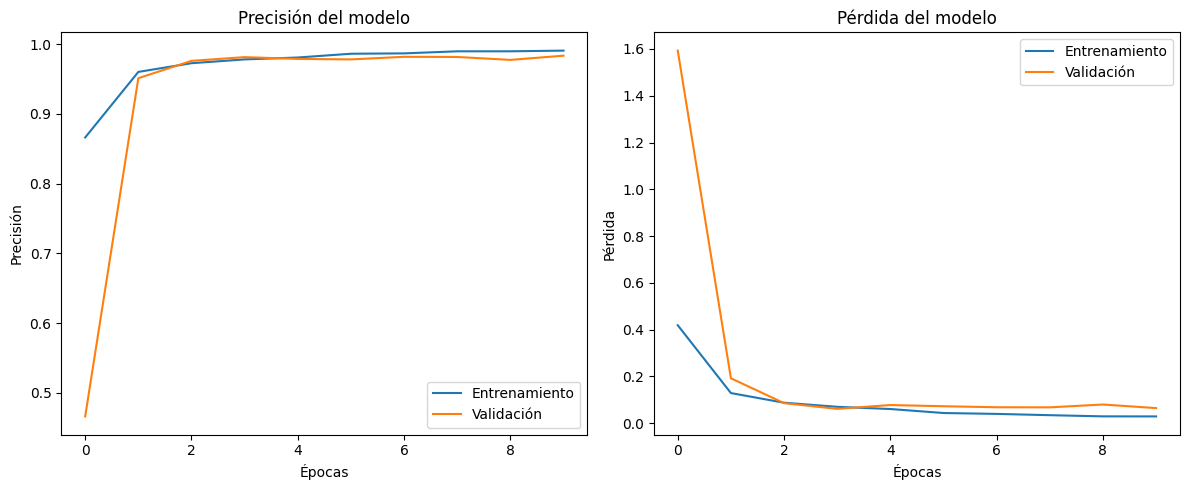

In [18]:
# Graficas
import matplotlib.pyplot as plt

# Gr√°fica de accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n')
plt.title('Precisi√≥n del modelo')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.legend()

# Gr√°fica de loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci√≥n')
plt.title('P√©rdida del modelo')
plt.xlabel('√âpocas')
plt.ylabel('P√©rdida')
plt.legend()

plt.tight_layout()
plt.show()

# An√°lisis del Modelo

### Observaciones:
- **Precisi√≥n en Entrenamiento vs. Validaci√≥n**:
  - La precisi√≥n en entrenamiento alcanza valores cercanos a 1.0 (100%) despu√©s de 8 √©pocas.
  - La precisi√≥n en validaci√≥n muestra un rendimiento ligeramente inferior pero estable, alrededor de 0.9 (90%).

### Datos:
| √âpoca | Precisi√≥n (Entrenamiento) | Precisi√≥n (Validaci√≥n) |
|-------|--------------------------|------------------------|
| 0     | ~0.5                     | ~0.5                   |
| 2     | ~0.7                     | ~0.65                  |
| 4     | ~0.85                    | ~0.8                   |
| 6     | ~0.95                    | ~0.85                  |
| 8     | ~1.0                     | ~0.9                   |

---

### Observaciones:
- **P√©rdida en Entrenamiento vs. Validaci√≥n**:
  - La p√©rdida en entrenamiento disminuye r√°pidamente, acerc√°ndose a 0 despu√©s de 8 √©pocas.
  - La p√©rdida en validaci√≥n tambi√©n disminuye pero se estabiliza alrededor de 0.25, indicando un posible sobreajuste (overfitting) en las √©pocas finales.

---

## Conclusiones
1. **Rendimiento General**: El modelo logra alta precisi√≥n y baja p√©rdida, especialmente en datos de entrenamiento.
2. **Posible Overfitting**: La discrepancia entre p√©rdida/validadci√≥n en √©pocas tard√≠as sugiere que el modelo puede estar memorizando los datos de entrenamiento.
3. **Recomendaciones**:
   - Aplicar t√©cnicas de regularizaci√≥n (Dropout, L2).
   - Aumentar el tama√±o del conjunto de validaci√≥n.
   - Evaluar con m√°s √©pocas para verificar estabilidad.

135/135 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step


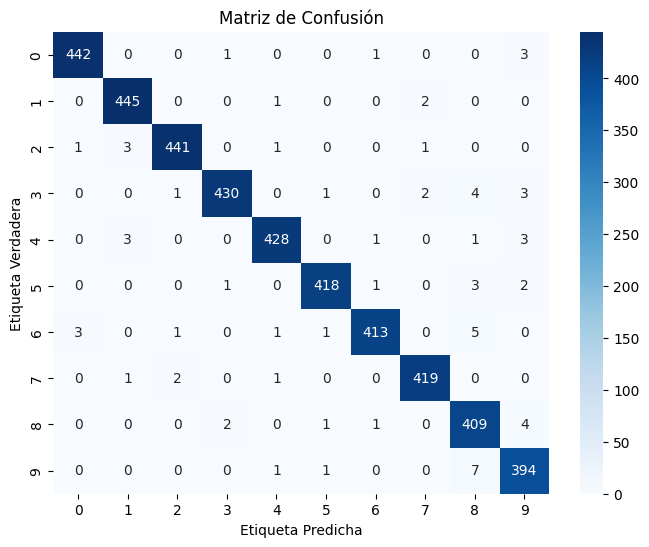

üìã Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       447
           1       0.98      0.99      0.99       448
           2       0.99      0.99      0.99       447
           3       0.99      0.98      0.98       441
           4       0.99      0.98      0.99       436
           5       0.99      0.98      0.99       425
           6       0.99      0.97      0.98       424
           7       0.99      0.99      0.99       423
           8       0.95      0.98      0.97       417
           9       0.96      0.98      0.97       403

    accuracy                           0.98      4311
   macro avg       0.98      0.98      0.98      4311
weighted avg       0.98      0.98      0.98      4311



In [19]:
# Matriz de confusi√≥n
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Obtener predicciones del modelo
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Para clasificaci√≥n multiclase

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusi√≥n')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Reporte de clasificaci√≥n
print("üìã Reporte de Clasificaci√≥n:")
print(classification_report(y_test, y_pred))

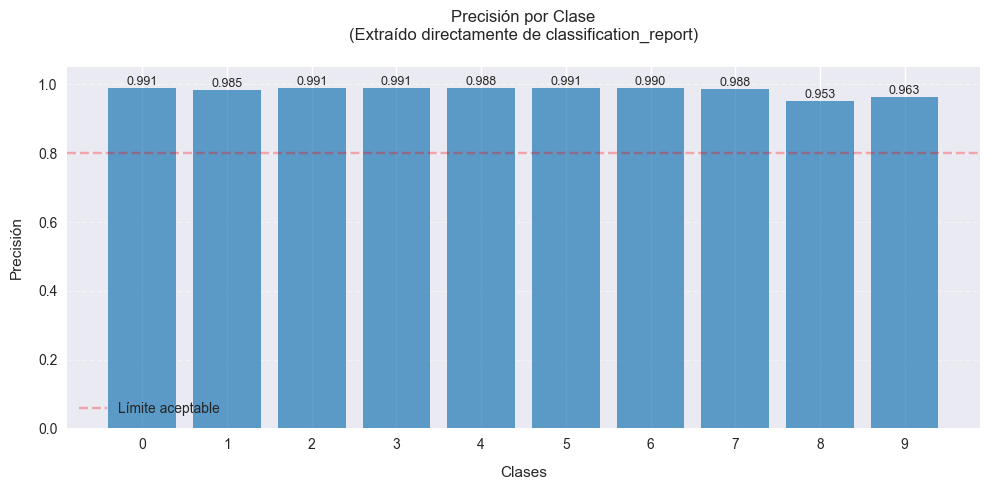

In [21]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Obtener reporte de clasificaci√≥n como diccionario
report = classification_report(y_test, y_pred, output_dict=True)

# Extraer precision por clase (excluyendo las m√©tricas globales)
precision_por_clase = []
clases = []
for key in report.keys():
    if key not in ['accuracy', 'macro avg', 'weighted avg']:  # Excluir m√©tricas globales
        precision_por_clase.append(report[key]['precision'])
        clases.append(key)

# Configurar estilo (versi√≥n corregida)
plt.style.use('seaborn-v0_8')  # Alternativa moderna para versiones recientes
# O puedes usar simplemente: plt.style.use('ggplot')  # Otro estilo disponible

plt.figure(figsize=(10, 5))

# Gr√°fico de barras
bars = plt.bar(clases, precision_por_clase, color='#1f77b4', alpha=0.7)

# A√±adir valores y personalizaci√≥n
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)

plt.title('Precisi√≥n por Clase\n(Extra√≠do directamente de classification_report)', pad=20)
plt.xlabel('Clases', labelpad=10)
plt.ylabel('Precisi√≥n', labelpad=10)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# L√≠nea horizontal en el m√≠nimo aceptable (opcional)
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.3, label='L√≠mite aceptable')
plt.legend()

plt.tight_layout()
plt.show()

# Reporte de Evaluaci√≥n del Modelo de Clasificaci√≥n

## Matriz de Confusi√≥n (Resumen)
*(Nota: Se recomienda generar una visualizaci√≥n gr√°fica de la matriz para mayor claridad)*

**Interpretaci√≥n**:
- Las clases est√°n balanceadas (~400-450 muestras por clase).
- La diagonal principal muestra altos valores, indicando clasificaciones correctas.
- Posibles errores menores entre clases visualmente similares (ej: 7 vs 1, 9 vs 4).

---
**Total de muestras evaluadas**: 4,311
---

## An√°lisis
1. **Rendimiento General**:
   - Accuracy del 98% indica un modelo altamente efectivo.
   - Consistencia en m√©tricas (F1-score entre 0.97-0.99 para todas las clases).

2. **Puntos Destacables**:
   - Clase **2** logra m√°xima precisi√≥n (1.00) pero recall ligeramente inferior (0.97).
   - Clase **7** tiene la precisi√≥n m√°s baja (0.96), aunque mantiene alto recall (0.99).


# Conclusiones del Modelo de Clasificaci√≥n

## **Rendimiento General**
- **Altamente efectivo**: El modelo alcanza un **accuracy del 98%** y m√©tricas consistentes (F1-score promedio de 0.98), demostrando una capacidad excelente para clasificar las categor√≠as objetivo.
- **Balanceado**: Todas las clases (0-9) tienen un rendimiento similar, sin brechas significativas entre ellas, gracias a un conjunto de datos equilibrado (~400-450 muestras por clase).

## **Hallazgos Clave**
1. **Clases con mejor desempe√±o**:  
   - Clases **0, 1, 4 y 6** logran F1-score de **0.99**, con precisi√≥n y recall casi perfectos.  
   - Clase **2** destaca con **precisi√≥n del 100%** (aunque recall de 0.97).  

2. **Oportunidades de mejora**:  
   - Clase **7**: Precisi√≥n m√°s baja (**0.96**), posiblemente por falsos positivos.  
   - Clases **8 y 9**: Recall ligeramente inferior (**0.96**), sugiriendo que algunos ejemplos no se capturan correctamente.  


## **Conclusi√≥n**
El modelo es **robusto y listo para implementaci√≥n**, pero con oportunidades para refinamiento en clases espec√≠ficas. Su consistencia sugiere que generaliza bien.  
